In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir(r'/content/drive/My Drive/ECE1512')

Mounted at /content/drive


In [2]:
import os, sys
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import cv2
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from skimage.segmentation import mark_boundaries

In [3]:
# setup plot params
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

#Part 2

###Task 3

LOAD CNN trained model and test datasets

In [4]:
# Load HMT Test Dataset
test_dir = './hmt_dataset/HMT_test'

test_datagen = ImageDataGenerator(rescale=1/255.)

print('generating test images...')
test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=496,
shuffle=False)

generating test images...
Found 496 images belonging to 8 classes.


In [5]:
# Loading  HMT trained model
model_hmt=load_model('./models/HMT.h5')

In [6]:
# Test images and prediction array
test_generator.reset()
image_batch,label_batch=test_generator.next()
predict_out=model_hmt(image_batch)

In [7]:
# classification accuracy

classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adipose', 'Empty']

y_test = [np.argmax(x) for x in label_batch]
y_predict = [np.argmax(x) for x in predict_out]

#Overall accuracy
accuracy = metrics.accuracy_score(y_test, y_predict)
print('Overall Accuracy: ', accuracy)

#Confusion matrix
ConfMatrix = metrics.confusion_matrix(y_test, y_predict)
class_acc = {}
for i in range(len(ConfMatrix)):
  class_acc[classes[i]] = [ConfMatrix[i][i], sum(ConfMatrix[i])-ConfMatrix[i][i], ConfMatrix[i][i]/sum(ConfMatrix[i])]

print(class_acc)

#precision
prec = metrics.precision_score(y_test, y_predict, average='macro')
print('precision: ', prec)

#recall
rec = metrics.recall_score(y_test, y_predict, average='macro', zero_division=0)
print('recall: ', rec)

#F-1
F1 = 2 * (prec * rec) / (prec + rec)
print('F-1: ', F1)

Overall Accuracy:  0.8346774193548387
{'Tumor': [53, 9, 0.8548387096774194], 'Stroma': [47, 15, 0.7580645161290323], 'Complex': [48, 14, 0.7741935483870968], 'Lympho': [53, 9, 0.8548387096774194], 'Debris': [41, 21, 0.6612903225806451], 'Mucosa': [51, 11, 0.8225806451612904], 'Adipose': [59, 3, 0.9516129032258065], 'Empty': [62, 0, 1.0]}
precision:  0.8475563179510548
recall:  0.8346774193548387
F-1:  0.8410675693120249


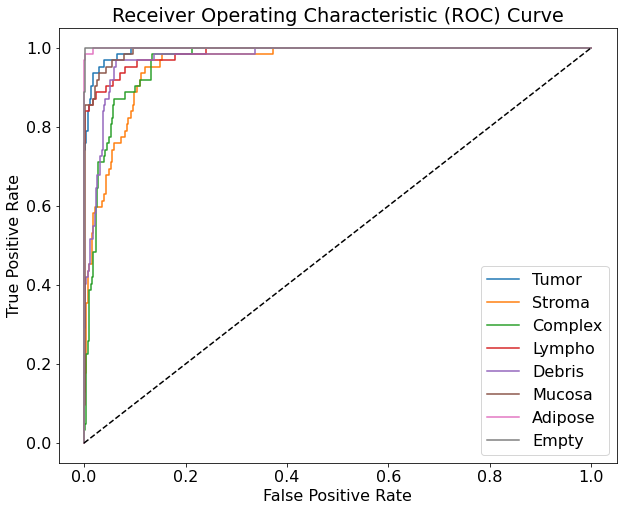

auc scores


{'Adipose': 0.9996655269808236,
 'Complex': 0.9655492790248253,
 'Debris': 0.9751003419057529,
 'Empty': 0.9997398543184183,
 'Lympho': 0.9864724245577523,
 'Mucosa': 0.9919726475397651,
 'Stroma': 0.9584881819533224,
 'Tumor': 0.9944626133491898}

In [ ]:
# roc curves and auc scores by class

y_test_bin = label_binarize(y_test, classes=range(len(classes)))
auc = {}

fig1 = plt.figure(figsize=(10,8))
for i in range(len(classes)):
  fpr, tpr, thres = metrics.roc_curve(y_test_bin[:,i], prediction[:,i])
  auc[classes[i]] = metrics.roc_auc_score(y_test_bin[:,i], prediction[:,i])
  plt.plot(fpr, tpr, label=classes[i])

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
fig1.savefig('roc_hmt.png', bbox_inches='tight')

print('auc scores')
auc

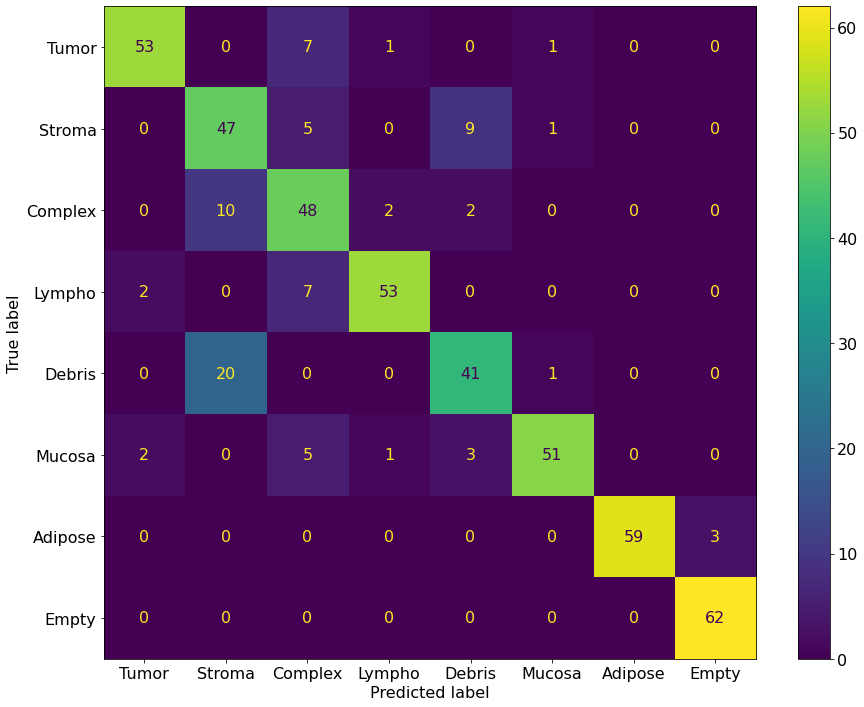

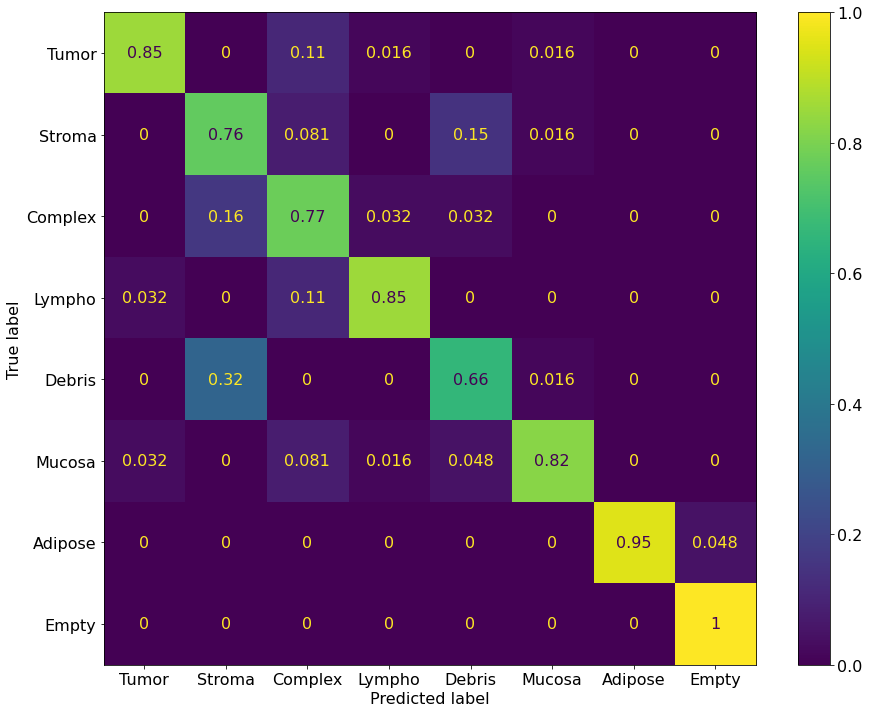

In [ ]:
# confusion matrix

fig1 = plt.figure(figsize=(15,12))
ax1 = plt.axes()
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax1)
fig1.savefig('cm_hmt.png', bbox_inches='tight')

# normalized
norm_cm = np.array([line/sum(line) for line in cm])

fig2 = plt.figure(figsize=(15,12))
ax2 = plt.axes()
disp_norm = metrics.ConfusionMatrixDisplay(confusion_matrix=norm_cm, display_labels=classes)
disp_norm.plot(ax=ax2)
fig2.savefig('cm_hmt_norm.png', bbox_inches='tight')

Debris images classified as Stroma


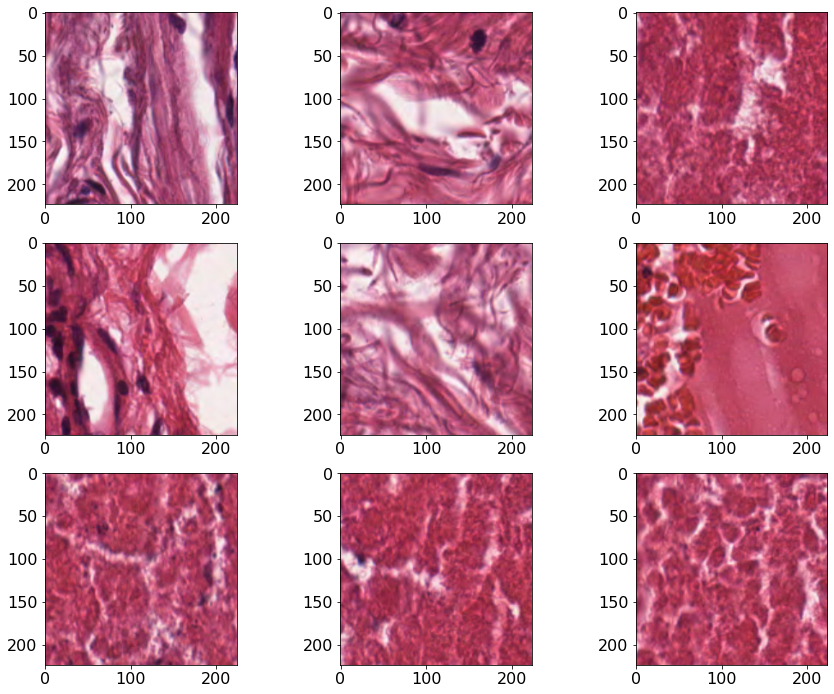

In [ ]:
# 1.2 show some qualitative examples of success/failure cases of the model. Among which two classes misclassification happens the most?
# from the confusion matrix, most misclassification occurs in Debris and Stroma

ind_debris = classes.index('Debris')
ind_stroma = classes.index('Stroma')

# Select Debris class. as Stroma
img_debris_stroma = [image_batch[i] for i in range(len(image_batch)) if y_test[i] == ind_debris and y_predict[i] == ind_stroma]

print('Debris images classified as Stroma')
fig1 = plt.figure(figsize=(15,12))

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(img_debris_stroma[i])

fig1.savefig('hmt_debris_as_stroma.png', bbox_inches='tight')


Stroma images classified as Stroma


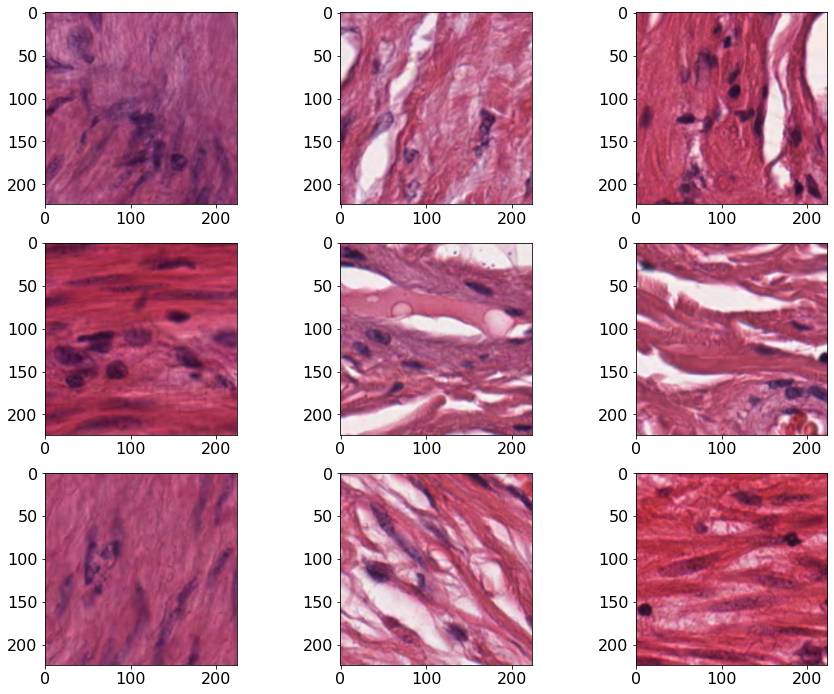

In [ ]:
# Select Stroma class. as Stroma
img_stroma = [image_batch[i] for i in range(len(image_batch)) if y_test[i] == ind_stroma and y_predict[i] == ind_stroma]

print('Stroma images classified as Stroma')
fig1 = plt.figure(figsize=(15,12))

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(img_stroma[i])

fig1.savefig('hmt_stroma_as_stroma.png', bbox_inches='tight')

Debris images classified as Debris


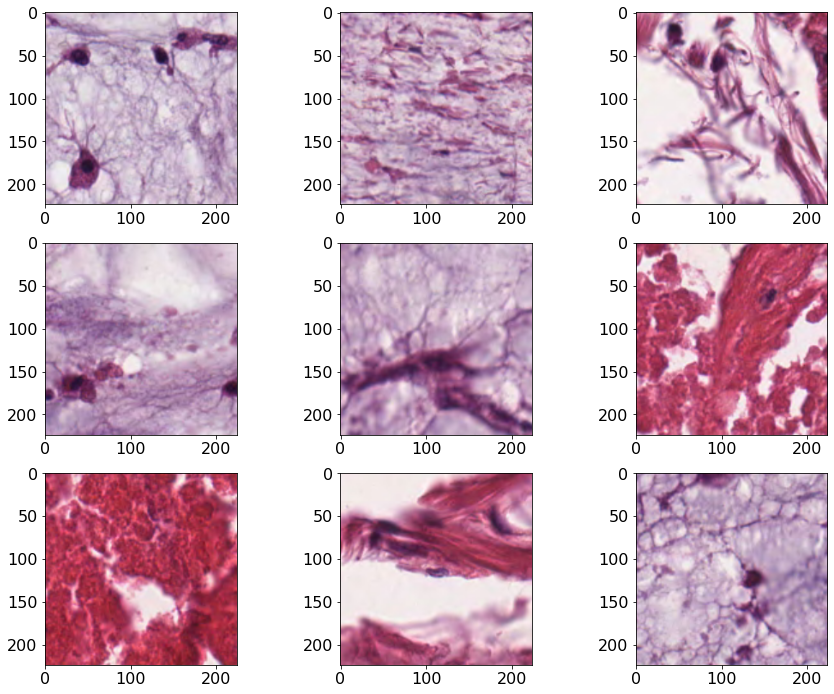

In [ ]:
# Select Debris class. as Debris
img_debris = [image_batch[i] for i in range(len(image_batch)) if y_test[i] == ind_debris and y_predict[i] == ind_debris]

print('Debris images classified as Debris')
fig1 = plt.figure(figsize=(15,12))

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(img_debris[i])

fig1.savefig('hmt_debris_as_debris.png', bbox_inches='tight')

Stroma images classified as Debris


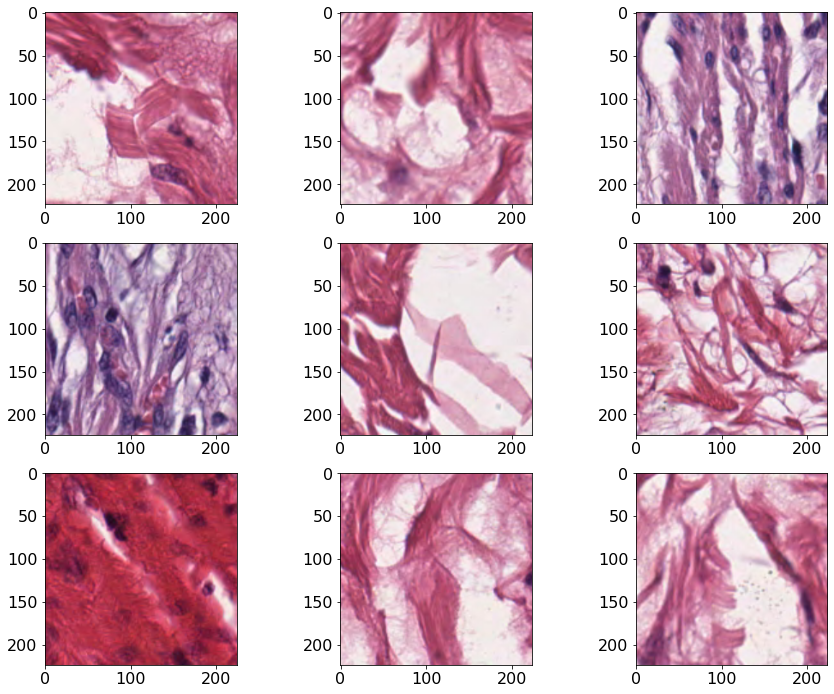

In [ ]:
# Select Stroma class. as Debris
img_stroma_debris = [image_batch[i] for i in range(len(image_batch)) if y_test[i] == ind_stroma and y_predict[i] == ind_debris]

print('Stroma images classified as Debris')
fig1 = plt.figure(figsize=(15,12))

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(img_stroma_debris[i])

fig1.savefig('hmt_stroma_as_debris.png', bbox_inches='tight')

#Grad-CAM

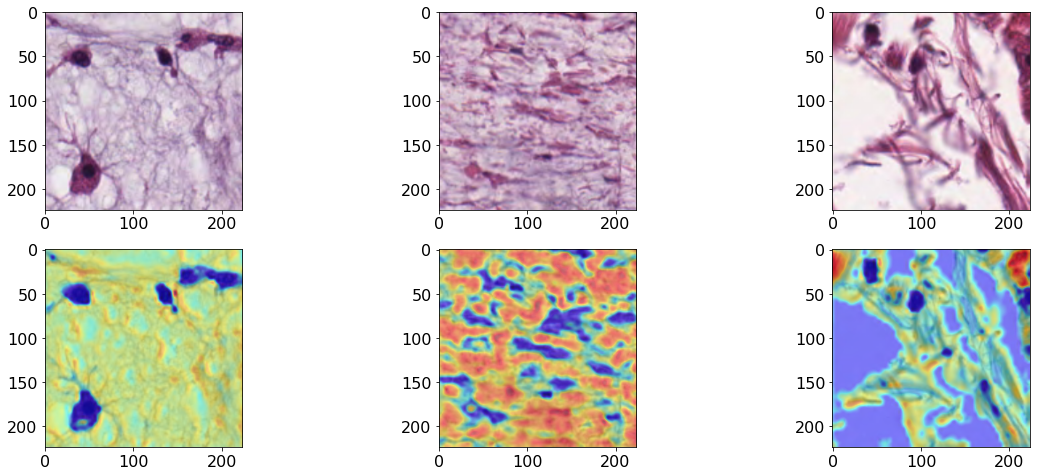

In [ ]:
# 2. repeat 2.a from Task#2 using two XAI methods

# generate grad-cam explanation maps for Debris
from xai_utils import grad_cam

map_GradCAM = []

for i in range(3):
  map_GradCAM.append(grad_cam(model, np.expand_dims(img_debris[i], axis=0), 'max_pooling2d_1'))
  map_GradCAM[i] = np.array(map_GradCAM[i])
  map_GradCAM[i] -= map_GradCAM[i].min()
  map_GradCAM[i] /= map_GradCAM[i].max()+10e-30

fig1 = plt.figure(figsize=(20,8))

for i in range(3):
  plt.subplot(2,3,i+1)
  plt.imshow(img_debris[i])
  

for i in range(3,6):
  plt.subplot(2,3,i+1)
  plt.imshow(img_debris[i-3])
  plt.imshow(map_GradCAM[i-3], cmap='jet', alpha=0.5)

fig1.savefig('hmt_debris_as_debris_gradcam.png', bbox_inches='tight')

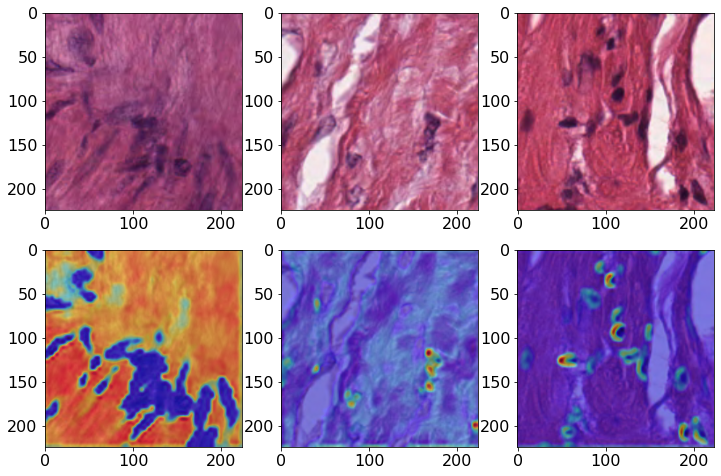

In [ ]:
# generate grad-cam explanation maps for Stroma
from xai_utils import grad_cam

map_GradCAM = []

for i in range(3):
  map_GradCAM.append(grad_cam(model, np.expand_dims(img_stroma[i], axis=0), 'max_pooling2d_1'))
  map_GradCAM[i] = np.array(map_GradCAM[i])
  map_GradCAM[i] -= map_GradCAM[i].min()
  map_GradCAM[i] /= map_GradCAM[i].max()+10e-30

fig1 = plt.figure(figsize=(12,8))

for i in range(3):
  plt.subplot(2,3,i+1)
  plt.imshow(img_stroma[i])

for i in range(3,6):
  plt.subplot(2,3,i+1)
  plt.imshow(img_stroma[i-3])
  plt.imshow(map_GradCAM[i-3], cmap='jet', alpha=0.5)

fig1.savefig('hmt_stroma_as_stroma_gradcam.png', bbox_inches='tight')

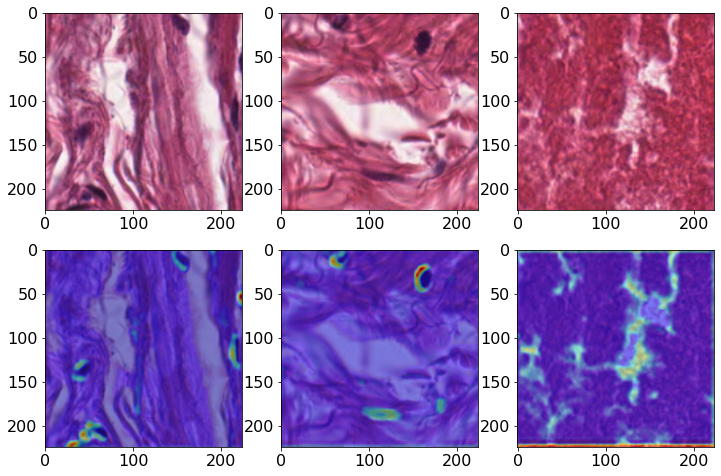

In [ ]:
# generate grad-cam explanation maps for Debris as Stroma
from xai_utils import grad_cam

map_GradCAM = []

for i in range(3):
  map_GradCAM.append(grad_cam(model, np.expand_dims(img_debris_stroma[i], axis=0), 'max_pooling2d_1'))
  map_GradCAM[i] = np.array(map_GradCAM[i])
  map_GradCAM[i] -= map_GradCAM[i].min()
  map_GradCAM[i] /= map_GradCAM[i].max()+10e-30

fig1 = plt.figure(figsize=(12,8))

for i in range(3):
  plt.subplot(2,3,i+1)
  plt.imshow(img_debris_stroma[i])

for i in range(3,6):
  plt.subplot(2,3,i+1)
  plt.imshow(img_debris_stroma[i-3])
  plt.imshow(map_GradCAM[i-3], cmap='jet', alpha=0.5)

fig1.savefig('hmt_debris_as_stroma_gradcam.png', bbox_inches='tight')

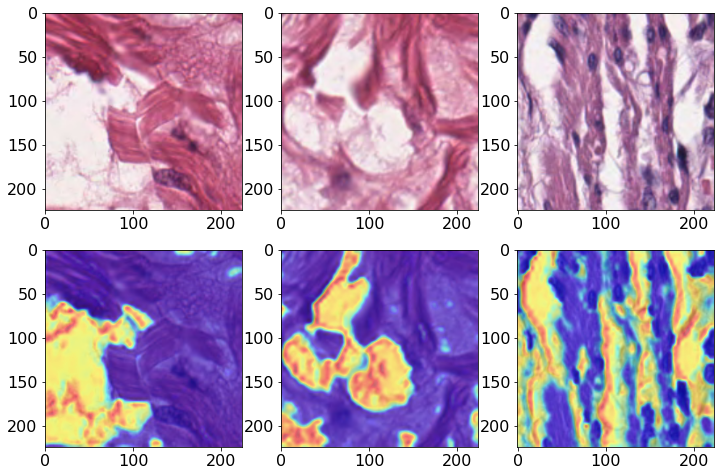

In [ ]:
# generate grad-cam explanation maps for Stroma as Debris
from xai_utils import grad_cam

map_GradCAM = []

for i in range(3):
  map_GradCAM.append(grad_cam(model, np.expand_dims(img_stroma_debris[i], axis=0), 'max_pooling2d_1'))
  map_GradCAM[i] = np.array(map_GradCAM[i])
  map_GradCAM[i] -= map_GradCAM[i].min()
  map_GradCAM[i] /= map_GradCAM[i].max()+10e-30

fig1 = plt.figure(figsize=(12,8))

for i in range(3):
  plt.subplot(2,3,i+1)
  plt.imshow(img_stroma_debris[i])

for i in range(3,6):
  plt.subplot(2,3,i+1)
  plt.imshow(img_stroma_debris[i-3])
  plt.imshow(map_GradCAM[i-3], cmap='jet', alpha=0.5)

fig1.savefig('hmt_stroma_as_debris_gradcam.png', bbox_inches='tight')

#SHAP

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 11.7 MB/s 


In [ ]:
#%%time
%load_ext autoreload
%autoreload 2

import shap

#img_debris = [image_batch[i] for i in range(len(image_batch)) if y_test[i] == ind_debris and y_predict[i] == ind_debris]

e = shap.GradientExplainer(model, [image_batch])
map_shap_debris = e.shap_values(np.array(img_debris[0:3]))
# map_shap_stroma = e.shap_values(img_stroma)

# map_shap_debris = map_shap_debris[0]
# for i in range(len(map_shap_debris)):
#   map_shap_debris[i] = map_shap_debris[:,:,0]
#   map_shap_debris[i] -= map_shap_debris[i].min()
#   map_shap_debris[i] /= map_shap_debris[i].max()+10e-30

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
map = map_shap_debris[0]

img = []
for i in range(len(map)):
  img.append(map[i][:,:,0])
  img[i] -= img[i].min()
  img[i] /= img[i].max()+10e-30

img_shap_debris = img

#plt.imshow(img[0], cmap='jet')

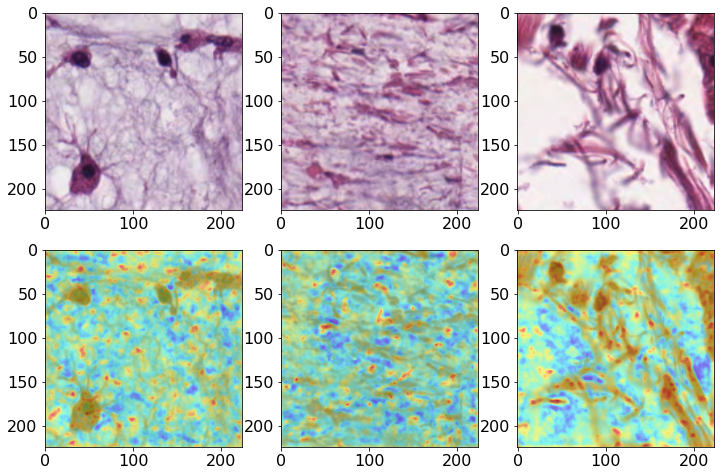

In [ ]:
# generate shap explanation maps for Debris

fig1 = plt.figure(figsize=(12,8))

for i in range(3):
  plt.subplot(2,3,i+1)
  plt.imshow(img_debris[i])

for i in range(3,6):
  plt.subplot(2,3,i+1)
  plt.imshow(img_debris[i-3])
  plt.imshow(img[i-3], cmap='jet', alpha=0.5)

fig1.savefig('hmt_debris_as_debris_shap.png', bbox_inches='tight')

In [ ]:
%%time
import shap

e = shap.GradientExplainer(model, [image_batch])
map_shap_stroma = e.shap_values(np.array(img_stroma[0:3]), 50)

map_shap_stroma = map_shap_stroma[0]

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


CPU times: user 3min 29s, sys: 3.21 s, total: 3min 32s
Wall time: 2min 1s


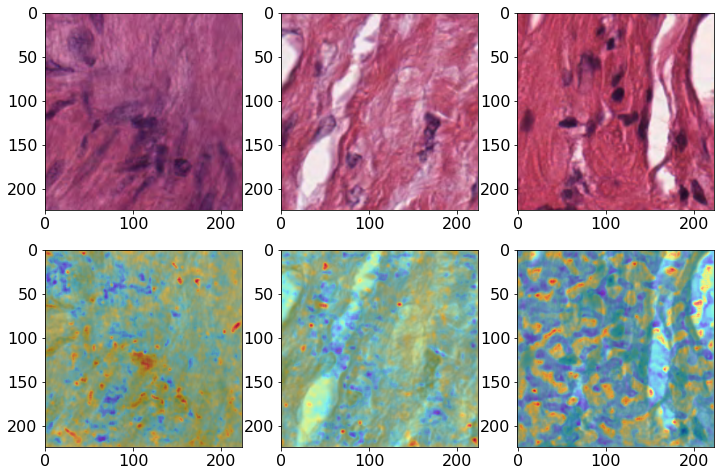

In [ ]:
# generate grad-cam explanation maps for Stroma

map = map_shap_stroma

img = []
for i in range(len(map)):
  img.append(map[i][:,:,0])
  img[i] -= img[i].min()
  img[i] /= img[i].max()+10e-30

fig1 = plt.figure(figsize=(12,8))

for i in range(3):
  plt.subplot(2,3,i+1)
  plt.imshow(img_stroma[i])

for i in range(3,6):
  plt.subplot(2,3,i+1)
  plt.imshow(img_stroma[i-3])
  plt.imshow(img[i-3], cmap='jet', alpha=0.5)

fig1.savefig('hmt_stroma_as_stroma_shap.png', bbox_inches='tight')

In [ ]:
%%time
import shap

e = shap.GradientExplainer(model, [image_batch])
map_shap_debris_stroma = e.shap_values(np.array(img_debris_stroma[0:3]), 50)

map_shap_debris_stroma = map_shap_debris_stroma[0]

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


CPU times: user 3min 29s, sys: 3.3 s, total: 3min 32s
Wall time: 2min 1s


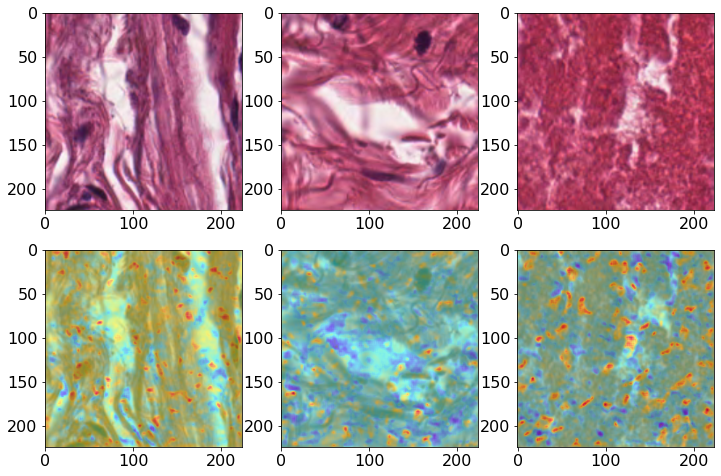

In [ ]:
# generate shap explanation maps for Debris as Stroma

map = map_shap_debris_stroma

img = []
for i in range(len(map)):
  img.append(map[i][:,:,0])
  img[i] -= img[i].min()
  img[i] /= img[i].max()+10e-30

fig1 = plt.figure(figsize=(12,8))

for i in range(3):
  plt.subplot(2,3,i+1)
  plt.imshow(img_debris_stroma[i])

for i in range(3,6):
  plt.subplot(2,3,i+1)
  plt.imshow(img_debris_stroma[i-3])
  plt.imshow(img[i-3], cmap='jet', alpha=0.5)

fig1.savefig('hmt_debris_as_stroma_shap.png', bbox_inches='tight')

In [ ]:
%%time
import shap

e = shap.GradientExplainer(model, [image_batch])
map_shap_stroma_debris = e.shap_values(np.array(img_stroma_debris[0:3]), 50)

map_shap_stroma_debris = map_shap_stroma_debris[0]

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


CPU times: user 3min 28s, sys: 3.22 s, total: 3min 32s
Wall time: 2min


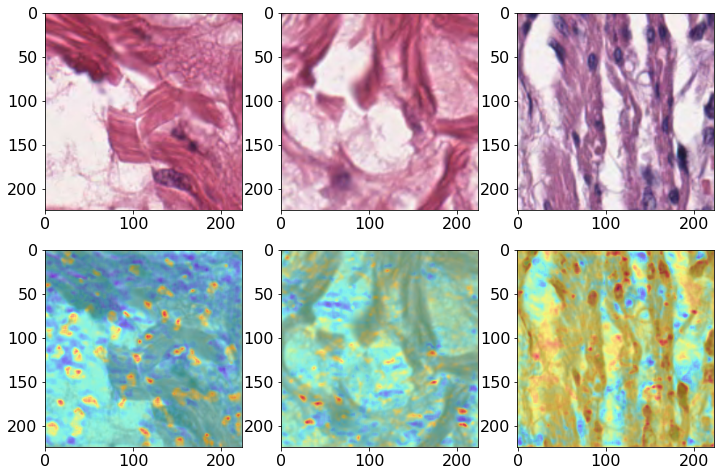

In [ ]:
# generate shap explanation maps for Stroma as Debris

map = map_shap_stroma_debris

img = []
for i in range(len(map)):
  img.append(map[i][:,:,0])
  img[i] -= img[i].min()
  img[i] /= img[i].max()+10e-30

fig1 = plt.figure(figsize=(12,8))

for i in range(3):
  plt.subplot(2,3,i+1)
  plt.imshow(img_stroma_debris[i])

for i in range(3,6):
  plt.subplot(2,3,i+1)
  plt.imshow(img_stroma_debris[i-3])
  plt.imshow(img[i-3], cmap='jet', alpha=0.5)

fig1.savefig('hmt_stroma_as_debris_shap.png', bbox_inches='tight')

###Task 4

In [ ]:
# apply drop% and increase% metrics to evaluate the performance of selected attribution method

# HMT: k = 90%
# calculate average drop% and increase% on the whole test set

from xai_utils import img_to_array

def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
ind_tumor = classes.index('Tumor')
img_tumor = [image_batch[i] for i in range(len(image_batch)) if y_test[i] == ind_tumor and y_predict[i] == ind_tumor]

In [ ]:
# generate maps (GradCAM) and drop rates for tumor class

maps_tumor_GradCAM = []
for img in img_tumor:
  maps_tumor_GradCAM.append(grad_cam(model, np.expand_dims(img, axis=0), 'max_pooling2d_1'))

drop_tumor_GradCAM = []
for i in range(len(img_tumor)):
  drop_tumor_GradCAM.append(calculate_drop_increase(np.expand_dims(img_tumor[i], axis=0), model, maps_tumor_GradCAM[i], class_index=0, frac=0.9)[0])


In [ ]:
drop_tumor_GradCAM

[0.17793807534364783,
 -0.0,
 0.001306503355142472,
 -0.0,
 0.009442669788540312,
 9.69689683199518e-05,
 -0.0,
 -0.0,
 -0.0,
 0.0024295113843118945,
 2.1646293012689916e-05,
 0.06276006121595389,
 -0.0,
 0.07998751450204085,
 0.638512445297154,
 -0.0,
 0.12134229029331754,
 0.7291928541456969,
 0.04180054060358508,
 0.1865889835967084,
 0.009277418591689013,
 0.49024340162695423,
 -0.0,
 0.0031799832432020717,
 -0.0,
 0.009653895900897285,
 0.0065476592882187925,
 -0.0,
 0.02082687858808375,
 -0.0,
 -0.0,
 -0.0,
 0.5129884513995306,
 -0.0,
 0.017785298183427084,
 0.22524315214419585,
 0.004321444867955155,
 0.024659167091847192,
 2.3128670037094096e-05,
 -0.0,
 -0.0,
 0.01722763384357665,
 -0.0,
 0.09012312012182168,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 0.5375935162094763,
 0.16632585317568546,
 -0.0,
 -0.0]

In [ ]:
# generate maps (SHAP) and drop rates for tumor class

import shap

e = shap.GradientExplainer(model, [image_batch])
shap_values = e.shap_values(np.array(img_tumor), 5)

shap_values = shap_values[0]

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
maps_tumor_SHAP = []
for img in shap_values:
  maps_tumor_SHAP.append(img[:,:,0])

drop_tumor_SHAP = []
for i in range(len(img_tumor)):
  drop_tumor_SHAP.append(calculate_drop_increase(np.expand_dims(img_tumor[i], axis=0), model, maps_tumor_SHAP[i], class_index=0, frac=0.9)[0])

In [ ]:
drop_tumor_SHAP

[0.5628836930196757,
 0.026493482608300773,
 0.038518409648775426,
 0.0026097958451044494,
 0.9926389323387657,
 0.01493960222804394,
 0.9872214932205249,
 0.4859646603190913,
 0.30100169057488535,
 0.00667635621353665,
 0.03559067992914566,
 0.02630526257433836,
 0.010843059921119542,
 0.9975455539512611,
 0.9861835085964592,
 0.0028204758956273117,
 0.9327280879585806,
 0.9473794136521257,
 0.985634439934934,
 0.772612230014536,
 0.9209129801216084,
 0.9943230364626361,
 0.9912946885408196,
 0.016854036542617495,
 0.0005470011917069517,
 0.020387239770488244,
 0.12737873315468562,
 0.019513944970843414,
 0.6553341625267042,
 0.11607164192361713,
 0.9995135997221697,
 0.9031650320578651,
 0.8154816167666686,
 0.026849705118428633,
 0.07533238842954167,
 0.9054498944634706,
 0.01665421444891833,
 0.9085279966397599,
 0.0016318826570502266,
 0.04171473102414366,
 0.20399033242263295,
 0.7199712542708242,
 0.1189004246149722,
 0.6040427688463065,
 0.9883525705930055,
 0.02493977400260513

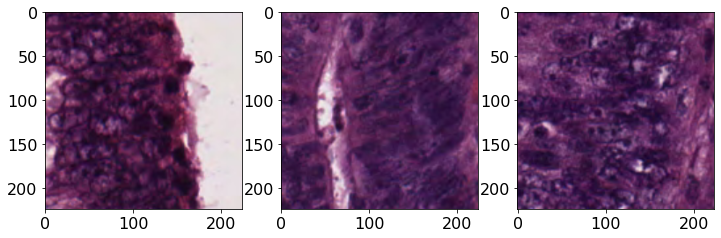

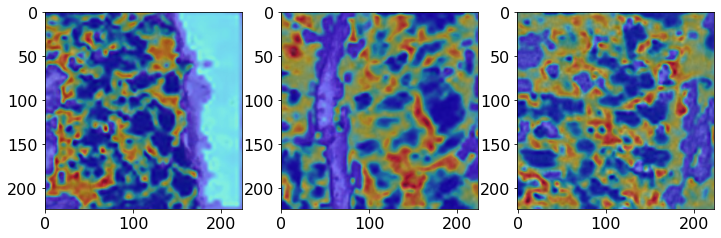

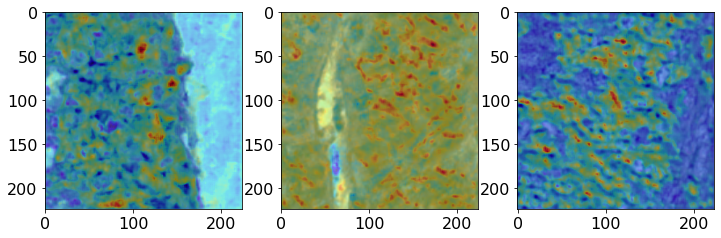

In [ ]:
# examples of explanation maps for tumor class
# GradCAM drop rates: 0.17793414736119537, 0.0, 0.001306503355142472
# SHAP drop rates: 0.944540692536343, 0.012138283626258796, 0.04094581515016507

fig1 = plt.figure(figsize=(12,8))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.imshow(img_tumor[i])

fig2 = plt.figure(figsize=(12,8))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.imshow(img_tumor[i])
  plt.imshow(maps_tumor_GradCAM[i], cmap='jet', alpha=0.5)

fig3 = plt.figure(figsize=(12,8))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.imshow(img_tumor[i])
  plt.imshow(maps_tumor_SHAP[i], cmap='jet', alpha=0.5)

fig1.savefig('hmt_tumor_0_2.png', bbox_inches='tight')
fig2.savefig('hmt_tumor_gradcam.png', bbox_inches='tight')
fig3.savefig('hmt_tumor_shap.png', bbox_inches='tight')

In [ ]:
import random

ind_sample = random.sample(range(492), 100)

In [ ]:
img_sample = np.array([image_batch[i] for i in ind_sample])

In [ ]:
%%time
# generate maps (SHAP) and drop rates for sampled classes

import shap

e = shap.GradientExplainer(model, [image_batch])
shap_values = e.shap_values(img_sample, 10)

shap_values = shap_values[0]

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


CPU times: user 23min 37s, sys: 1min 35s, total: 25min 12s
Wall time: 14min 57s


In [ ]:
maps_sample_SHAP = []
for img in shap_values:
  maps_sample_SHAP.append(img[:,:,0])

drop_sample_SHAP = []
for i in range(len(img_sample)):
  drop_sample_SHAP.append(calculate_drop_increase(np.expand_dims(img_sample[i], axis=0), model, maps_sample_SHAP[i], class_index=np.argmax(label_batch[ind_sample[i]]), frac=0.9)[0])

In [ ]:
# average drop rate for SHAP
np.sum(drop_sample_SHAP) / len(drop_sample_SHAP)

0.6084673470719104

In [ ]:
# average increase rate for SHAP

inc_sample_SHAP = []
for i in range(len(img_sample)):
  inc_sample_SHAP.append(calculate_drop_increase(np.expand_dims(img_sample[i], axis=0), model, maps_sample_SHAP[i], class_index=np.argmax(label_batch[ind_sample[i]]), frac=0.9)[1])

In [ ]:
# average increase rate for SHAP
np.sum(inc_sample_SHAP) / len(inc_sample_SHAP)

0.26

In [ ]:
maps_sample_GradCAM = []
for img in img_sample:
  maps_sample_GradCAM.append(grad_cam(model, np.expand_dims(img, axis=0), 'max_pooling2d_1'))

drop_sample_GradCAM = []
for i in range(len(img_sample)):
  drop_sample_GradCAM.append(calculate_drop_increase(np.expand_dims(img_sample[i], axis=0), model, maps_sample_GradCAM[i], class_index=np.argmax(label_batch[ind_sample[i]]), frac=0.9)[0])

In [ ]:
# average drop rate for GradCAM
np.sum(drop_sample_GradCAM) / len(drop_sample_GradCAM)

0.5409897596675289

In [ ]:
# average increase rate for GradCAM

inc_sample_GradCAM = []
for i in range(len(img_sample)):
  inc_sample_GradCAM.append(calculate_drop_increase(np.expand_dims(img_sample[i], axis=0), model, maps_sample_GradCAM[i], class_index=np.argmax(label_batch[ind_sample[i]]), frac=0.9)[1])

In [ ]:
# average increase rate for GradCAM
np.sum(inc_sample_GradCAM) / len(inc_sample_GradCAM)

0.22